In [6]:
import pulp
import pandas as pd
import numpy as np

class PuLP_Solver_Capsule:
    def __init__(self, name="MCM_Optimization", sense='max'):
        """
        初始化优化器
        :param name: 问题名称
        :param sense: 'max' (最大化) 或 'min' (最小化)
        """
        self.sense = pulp.LpMaximize if sense == 'max' else pulp.LpMinimize
        self.prob = pulp.LpProblem(name, self.sense)
        self.vars = {}  # 存储所有变量对象
        self.constraints = {} # 存储约束引用
        self.objective_terms = [] # 存储目标函数项，用于审计
        self.is_solved = False

    def add_variables(self, names, low_bound=0, up_bound=None, cat='Continuous'):
        """
        批量添加变量 (Phase 1 关键步骤)
        :param names: 变量名列表 (如 ['x1', 'x2'] 或 Sku_List)
        :param cat: 'Continuous' (连续), 'Integer' (整数), 'Binary' (0/1)
        """
        # PuLP 的 category 映射
        cat_map = {
            'Continuous': pulp.LpContinuous,
            'Integer': pulp.LpInteger,
            'Binary': pulp.LpBinary
        }
        
        # 创建变量字典
        new_vars = pulp.LpVariable.dicts(
            "Var", 
            names, 
            lowBound=low_bound, 
            upBound=up_bound, 
            cat=cat_map.get(cat, pulp.LpContinuous)
        )
        
        # 更新全局变量库，允许通过原始名称访问
        self.vars.update(new_vars)
        print(f"✅ 已添加 {len(names)} 个变量 (类型: {cat})")
        return new_vars

    def set_weighted_objective(self, weights_dict, objectives_dict, normalize=True):
        """
        设置加权目标函数 (支持多目标归一化)
        :param weights_dict: 权重字典 {'Cost': 0.6, 'Sat': 0.4}
        :param objectives_dict: 目标表达式字典 {'Cost': lpSum(...), 'Sat': lpSum(...)}
        :param normalize: 是否进行最大最小归一化 (简易版，除以预估最大值)
        """
        # 注意：PuLP 不支持非线性，这里假设 objectives_dict 里已经是线性表达式对象
        
        final_obj = 0
        print("🎯 正在构建加权目标函数...")
        
        for name, expr in objectives_dict.items():
            w = weights_dict.get(name, 0)
            
            # 简单的量纲对齐逻辑 (实际比赛建议在外部计算好 scaling factor)
            # 这里仅做演示，不做自动缩放以防黑箱操作
            term = w * expr
            
            # 如果是最小化问题中的“最大化子目标”（如满意度），需要反向
            # 这里假设用户在外部已经处理好了符号（例如 Minimize Cost - Satisfaction）
            
            final_obj += term
            print(f"   -> 添加目标项: {name} (权重: {w})")
            
        self.prob += final_obj
        self.objective_terms = objectives_dict # 记录用于后续分析

    def add_constraint(self, expr, sense, rhs, name):
        """
        添加约束 (Phase 2 审计重点)
        :param expr: 线性表达式 (如 pulp.lpSum(...))
        :param sense: '<=', '>=', '=='
        :param rhs: 右边常数 (Right Hand Side)
        :param name: 约束名称 (必须唯一，用于审计)
        """
        if sense == '<=':
            constraint = (expr <= rhs)
        elif sense == '>=':
            constraint = (expr >= rhs)
        elif sense == '==':
            constraint = (expr == rhs)
        else:
            raise ValueError("Sense must be <=, >=, or ==")
            
        self.prob += constraint, name
        self.constraints[name] = constraint

    def solve(self, solver=None):
        """
        求解模型 (Phase 3 RPG核心)
        """
        print("\n🚀 开始求解...")
        # 默认使用 CBC solver，不仅免费而且够快
        status = self.prob.solve(solver if solver else pulp.PULP_CBC_CMD(msg=0))
        self.status = pulp.LpStatus[status]
        self.is_solved = True
        
        print(f"📊 求解状态: {self.status}")
        if self.status == 'Optimal':
            print(f"💎 目标函数值: {pulp.value(self.prob.objective)}")
        else:
            print("⚠️ 警告: 未找到最优解，请检查约束冲突！")
            
        return self.status

    def export_audit_matrix(self):
        """
        导出约束矩阵用于审计 (Phase 2 核心功能)
        返回: DataFrame (行=约束, 列=变量系数 + RHS)
        """
        # 这是一个解析 PuLP 内部结构的黑科技，用于生成人类可读的表格
        data = []
        
        for name, c in self.prob.constraints.items():
            row = {'_Constraint_Name': name}
            # 解析表达式中的变量系数
            for var, coeff in c.items():
                row[var.name] = coeff
            
            # 获取 RHS (注意 PuLP 内部存储是 expr + constant check 0)
            # 简单处理：直接读取约束的常数项
            row['_RHS'] = -c.constant 
            data.append(row)
            
        df = pd.DataFrame(data).fillna(0)
        return df

    def get_results_df(self):
        """
        获取结果表格 (Phase 5 交付)
        """
        if not self.is_solved:
            return None
        
        data = []
        for v in self.prob.variables():
            data.append({
                'Variable': v.name,
                'Value': v.varValue,
                'Type': v.cat
            })
        return pd.DataFrame(data)

    def get_shadow_prices(self):
        """
        获取影子价格 (Phase 4 灵敏度分析)
        注意：仅对连续变量模型有效，混合整数规划(MIP)通常无影子价格
        """
        data = []
        for name, c in self.prob.constraints.items():
            try:
                # pi 是影子价格，slack 是松弛变量
                data.append({
                    'Constraint': name,
                    'Shadow_Price': c.pi,
                    'Slack': c.slack
                })
            except:
                pass # MIP 问题可能无法获取
        return pd.DataFrame(data)

# ==========================================
# 指挥官备忘录 (Commander Cheat Sheet)
# ==========================================
# 1. 实例化: solver = PuLP_Solver_Capsule(sense='min')
# 2. 变量: vars = solver.add_variables(names_list, cat='Integer')
# 3. 构造表达式: expr = pulp.lpSum([vars[i] * cost[i] for i in names_list])
# 4. 目标: solver.set_weighted_objective({'Cost':1}, {'Cost': expr})
# 5. 约束: solver.add_constraint(expr, '<=', 100, 'Budget_Limit')
# 6. 审计: df_audit = solver.export_audit_matrix() -> 保存为xlsx检查
# 7. 求解: solver.solve()

In [3]:
import pandas as pd
import numpy as np

# 1. 读取数据
# 注意：虽然之前展示的是csv格式文本，但根据指令读取 xlsx 文件
file_path = '00_Cleaned_Data.xlsx'
df = pd.read_excel(file_path)

# 2. 提取唯一的 Supply Centers (Origin) 和 Shelters (Destination)
origins = df['Origin'].unique().tolist()
destinations = df['Destination'].unique().tolist()

# 3. 整理参数 (Capacity & Demand)
# 使用 drop_duplicates 提取每个地点的固有属性，并转为字典映射，方便后续 O(1) 复杂度查询
origin_capacity = df[['Origin', 'Origin_Capacity']].drop_duplicates().set_index('Origin')['Origin_Capacity'].to_dict()
dest_demand = df[['Destination', 'Dest_Demand']].drop_duplicates().set_index('Destination')['Dest_Demand'].to_dict()

# 提取 Route_ID 作为后续决策变量的 Key
route_ids = df['Route_ID'].tolist()

# ---------------------------------------------------------
# 4. 数据概况汇报 (Data Audit)
# ---------------------------------------------------------
total_supply = sum(origin_capacity.values())
total_demand = sum(dest_demand.values())

print("📊 === 数据概况汇报 (Data Audit) ===")
print(f"1. 节点统计:")
print(f"   - 后勤中心 (Origins): {len(origins)} 个 {origins}")
print(f"   - 安置点 (Destinations): {len(destinations)} 个 {destinations}")
print(f"   - 运输线路 (Routes): {len(route_ids)} 条 (将作为决策变量索引)")

print(f"\n2. 供需平衡分析:")
print(f"   - 总库存上限 (Total Capacity): {total_supply}")
print(f"   - 总物资需求 (Total Demand):   {total_demand}")

if total_supply >= total_demand:
    print(f"   ✅ 供给充足 (Surplus: {total_supply - total_demand})，可行解存在。")
else:
    print(f"   🚨 供给不足 (Deficit: {total_demand - total_supply})，模型可能无解！")

print("\n3. 关键参数映射示例 (前3条):")
print(df[['Route_ID', 'Origin', 'Destination', 'Cost_Per_Unit']].head(3).to_string(index=False))

📊 === 数据概况汇报 (Data Audit) ===
1. 节点统计:
   - 后勤中心 (Origins): 3 个 ['North_Hub', 'South_Hub', 'West_Hub']
   - 安置点 (Destinations): 5 个 ['Shelter_A', 'Shelter_B', 'Shelter_C', 'Shelter_D', 'Shelter_E']
   - 运输线路 (Routes): 15 条 (将作为决策变量索引)

2. 供需平衡分析:
   - 总库存上限 (Total Capacity): 1200
   - 总物资需求 (Total Demand):   880
   ✅ 供给充足 (Surplus: 320)，可行解存在。

3. 关键参数映射示例 (前3条):
Route_ID    Origin Destination  Cost_Per_Unit
Route_01 North_Hub   Shelter_A             12
Route_02 North_Hub   Shelter_B             15
Route_03 North_Hub   Shelter_C             20


In [7]:
import pandas as pd
import pulp 

# 1. 读取数据 (确保文件在当前目录下)
# 如果是 Excel 文件：
df = pd.read_excel('00_Cleaned_Data.xlsx')
# 如果是 CSV 文件，请使用: df = pd.read_csv('00_Cleaned_Data.xlsx - Sheet1.csv')

print("✅ 数据加载完成，开始建模...")

# 2. 实例化优化器 (目标：最小化成本)
solver = PuLP_Solver_Capsule(name="Relief_Logistics", sense='min')

# 3. 定义变量 (Phase 1)
# 提取 Route_ID 作为变量名
route_id_list = df['Route_ID'].tolist()

# 添加整数变量 (Integer), 下界为 0
route_vars = solver.add_variables(names=route_id_list, cat='Integer', low_bound=0)

# 4. 构建约束 (Phase 2)

# 4.1 库存约束 (Origin Capacity)
# 逻辑：对于每个出发地，流出的物资总和 <= 该地库存上限
for origin, group in df.groupby('Origin'):
    # 获取属于该 Origin 的所有 Route_ID
    r_ids = group['Route_ID'].tolist()
    # 获取该 Origin 的 Capacity (取第一行即可，因为是drop_duplicates后的属性)
    cap = group['Origin_Capacity'].iloc[0]
    
    # 构建表达式：Sum(x_routes)
    expr = pulp.lpSum([route_vars[rid] for rid in r_ids])
    
    # 添加约束
    solver.add_constraint(expr, '<=', cap, f"Cap_{origin}")

# 4.2 需求约束 (Dest Demand)
# 逻辑：对于每个目的地，流入的物资总和 >= 该地需求下限
for dest, group in df.groupby('Destination'):
    r_ids = group['Route_ID'].tolist()
    dem = group['Dest_Demand'].iloc[0]
    
    expr = pulp.lpSum([route_vars[rid] for rid in r_ids])
    
    solver.add_constraint(expr, '>=', dem, f"Dem_{dest}")

print(f"✅ 约束构建完成: 共 {len(solver.constraints)} 条约束")

# 5. 执行审计 (Export Audit Matrix)
# 导出约束矩阵以供检查
df_audit = solver.export_audit_matrix()
df_audit.to_excel("02_Audit_Matrix.xlsx", index=False)

print("\n🚀 审计矩阵已生成: '02_Audit_Matrix.xlsx'")
print("前3行预览:")
print(df_audit.head(3))

✅ 数据加载完成，开始建模...
✅ 已添加 15 个变量 (类型: Integer)
✅ 约束构建完成: 共 8 条约束

🚀 审计矩阵已生成: '02_Audit_Matrix.xlsx'
前3行预览:
  _Constraint_Name  Var_Route_01  Var_Route_02  Var_Route_03  Var_Route_04  \
0    Cap_North_Hub           1.0           1.0           1.0           1.0   
1    Cap_South_Hub           0.0           0.0           0.0           0.0   
2     Cap_West_Hub           0.0           0.0           0.0           0.0   

   Var_Route_05   _RHS  Var_Route_06  Var_Route_07  Var_Route_08  \
0           1.0  500.0           0.0           0.0           0.0   
1           0.0  400.0           1.0           1.0           1.0   
2           0.0  300.0           0.0           0.0           0.0   

   Var_Route_09  Var_Route_10  Var_Route_11  Var_Route_12  Var_Route_13  \
0           0.0           0.0           0.0           0.0           0.0   
1           1.0           1.0           0.0           0.0           0.0   
2           0.0           0.0           1.0           1.0           1.0   

   Var_Ro

In [8]:
# ---------------------------------------------------------
# Phase 3: 设定目标函数与求解 (Solver Execution)
# ---------------------------------------------------------

# 1. 准备参数映射 (构建 O(1) 查询字典)
cost_map = df.set_index('Route_ID')['Cost_Per_Unit'].to_dict()
time_map = df.set_index('Route_ID')['Time_Hours'].to_dict()

# 2. 构建目标项表达式 (Objectives Construction)
# 即使权重为0，我们也先把表达式建好，方便后续分析和切换
obj_cost = pulp.lpSum([route_vars[rid] * cost_map[rid] for rid in route_id_list])
obj_time = pulp.lpSum([route_vars[rid] * time_map[rid] for rid in route_id_list])

objectives_dict = {
    'Total_Cost': obj_cost,
    'Total_Time': obj_time
}

# 3. 设定权重 (当前策略：成本优先)
# 权重: Cost = 1.0, Time = 0.0
weights = {'Total_Cost': 1.0, 'Total_Time': 0.0}

solver.set_weighted_objective(weights, objectives_dict)

# 4. 求解模型
solver.solve()

# ---------------------------------------------------------
# 5. 结果展示 (Results Display)
# ---------------------------------------------------------
if solver.status == 'Optimal':
    # 获取结果并合并原始信息，只看有运输量的线路
    df_res = solver.get_results_df()
    
    # 提取变量名中的 Route_ID (格式: "Var_Route_01" -> "Route_01")
    # 注意：我们之前定义变量时，PuLP自动加了前缀 "Var_"，这里处理一下以便匹配
    df_res['Route_ID'] = df_res['Variable'].apply(lambda x: x.replace('Var_', ''))
    
    # 关联原始表获取 Origin/Dest 信息
    df_final = df_res.merge(df, on='Route_ID', how='left')
    
    # 筛选活跃线路 (运输量 > 0)
    active_routes = df_final[df_final['Value'] > 0].copy()
    
    # 计算单条线路的总成本以便展示
    active_routes['Line_Total_Cost'] = active_routes['Value'] * active_routes['Cost_Per_Unit']
    
    print("\n🚛 === 优化调度方案 (Active Routes) ===")
    cols_show = ['Route_ID', 'Origin', 'Destination', 'Value', 'Cost_Per_Unit', 'Line_Total_Cost']
    print(active_routes[cols_show].sort_values(by=['Origin', 'Destination']).to_string(index=False))
    
    print("-" * 60)
    print(f"💰 最终总运输成本 (Total Cost): {pulp.value(obj_cost):,.2f}")
    print(f"⏱️ 方案总耗时 (Total Time):     {pulp.value(obj_time):,.2f} (当前权重为0)")
    
else:
    print("⚠️ 模型求解失败，请检查审计矩阵中的约束逻辑。")

🎯 正在构建加权目标函数...
   -> 添加目标项: Total_Cost (权重: 1.0)
   -> 添加目标项: Total_Time (权重: 0.0)

🚀 开始求解...
📊 求解状态: Optimal
💎 目标函数值: 10560.0

🚛 === 优化调度方案 (Active Routes) ===
Route_ID    Origin Destination  Value  Cost_Per_Unit  Line_Total_Cost
Route_04 North_Hub   Shelter_D  250.0              8           2000.0
Route_06 South_Hub   Shelter_A  150.0             10           1500.0
Route_08 South_Hub   Shelter_C  100.0             12           1200.0
Route_10 South_Hub   Shelter_E   80.0             22           1760.0
Route_12  West_Hub   Shelter_B  200.0             11           2200.0
Route_15  West_Hub   Shelter_E  100.0             19           1900.0
------------------------------------------------------------
💰 最终总运输成本 (Total Cost): 10,560.00
⏱️ 方案总耗时 (Total Time):     2,105.00 (当前权重为0)


In [10]:
# ---------------------------------------------------------
# Phase 4: 灵敏度分析 (Linear Relaxation & Shadow Prices)
# ---------------------------------------------------------

print("💡 === 灵敏度分析说明 ===")
print("当前模型为整数规划(Integer)，其对偶值(Dual Values)通常无效。")
print("正在构建线性松弛模型(Linear Relaxation)以计算影子价格...\n")

# 1. 重新实例化 Solver (LP模式)
solver_lp = PuLP_Solver_Capsule(name="Relief_Logistics_LP_Relaxed", sense='min')

# 2. 定义变量 (关键修改: 类型设为 Continuous)
# 这允许物资出现 0.5 箱的情况，从而使函数可导，计算出影子价格
route_vars_lp = solver_lp.add_variables(names=route_id_list, cat='Continuous', low_bound=0)

# 3. 重建约束 (逻辑同 Phase 2)
# 3.1 库存约束
for origin, group in df.groupby('Origin'):
    r_ids = group['Route_ID'].tolist()
    cap = group['Origin_Capacity'].iloc[0]
    expr = pulp.lpSum([route_vars_lp[rid] for rid in r_ids])
    solver_lp.add_constraint(expr, '<=', cap, f"Cap_{origin}")

# 3.2 需求约束
for dest, group in df.groupby('Destination'):
    r_ids = group['Route_ID'].tolist()
    dem = group['Dest_Demand'].iloc[0]
    expr = pulp.lpSum([route_vars_lp[rid] for rid in r_ids])
    solver_lp.add_constraint(expr, '>=', dem, f"Dem_{dest}")

# 4. 重建目标 (逻辑同 Phase 3)
# 只需要成本目标
obj_cost_lp = pulp.lpSum([route_vars_lp[rid] * cost_map[rid] for rid in route_id_list])
solver_lp.set_weighted_objective({'Total_Cost': 1.0}, {'Total_Cost': obj_cost_lp})

# 5. 求解 LP
solver_lp.solve()

# ---------------------------------------------------------
# 6. 影子价格分析 (Shadow Price Interpretation)
# ---------------------------------------------------------
if solver_lp.status == 'Optimal':
    df_shadow = solver_lp.get_shadow_prices()
    
    # 分离出 供给侧(Cap) 和 需求侧(Dem) 的约束进行分析
    # 注意：在最小化问题中，
    # Capacity 约束 (<=) 的影子价格通常为负（放宽限制能降低成本），或者为0（非瓶颈）
    # Demand 约束 (>=) 的影子价格通常为正（增加需求会增加成本）
    
    # 提取 Supply Centers 的影子价格 (关注绝对值最大的，说明该仓库最紧缺，增加其库存能大幅降本)
    cap_shadows = df_shadow[df_shadow['Constraint'].str.startswith('Cap_')].copy()
    cap_shadows['Marginal_Value'] = cap_shadows['Shadow_Price'].abs() # 取绝对值看降本潜力
    
    # 提取 Shelters 的影子价格 (关注最大的，说明该安置点每增加1单位需求，成本增加最多)
    dem_shadows = df_shadow[df_shadow['Constraint'].str.startswith('Dem_')].copy()
    
    print(f"\n🔍 === 瓶颈分析报告 (Shadow Prices) ===")
    
    # 6.1 最紧缺的后勤中心
    # 排序找出边际价值最高的
    top_origin = cap_shadows.sort_values(by='Marginal_Value', ascending=False).iloc[0]
    
    print(f"🏭 最紧缺的后勤中心: {top_origin['Constraint']}")
    if top_origin['Marginal_Value'] > 0:
        print(f"   -> 影子价格: {top_origin['Shadow_Price']:.2f}")
        print(f"   -> 解释: 如果该中心能多发 1 单位物资，总运费预计下降 {top_origin['Marginal_Value']:.2f}。")
    else:
        print(f"   -> 解释: 所有仓库库存充足，增加库存无法降低当前成本 (Slack > 0)。")

    print("-" * 40)
    
    # 6.2 最昂贵的安置点
    # 排序找出增加需求导致成本飙升最快的点
    top_dest = dem_shadows.sort_values(by='Shadow_Price', ascending=False).iloc[0]
    
    print(f"⛺ 补给成本最高的安置点: {top_dest['Constraint']}")
    print(f"   -> 影子价格: {top_dest['Shadow_Price']:.2f}")
    print(f"   -> 解释: 如果该点需求增加 1 单位，总运费将增加 {top_dest['Shadow_Price']:.2f}。")
    
    # 展示完整表格供参考
    print("\n📋 完整影子价格表 (前5行):")
    print(df_shadow.head().to_string(index=False))

else:
    print("⚠️ 线性松弛模型求解失败，无法获取影子价格。")

💡 === 灵敏度分析说明 ===
当前模型为整数规划(Integer)，其对偶值(Dual Values)通常无效。
正在构建线性松弛模型(Linear Relaxation)以计算影子价格...

✅ 已添加 15 个变量 (类型: Continuous)
🎯 正在构建加权目标函数...
   -> 添加目标项: Total_Cost (权重: 1.0)

🚀 开始求解...
📊 求解状态: Optimal
💎 目标函数值: 10560.0

🔍 === 瓶颈分析报告 (Shadow Prices) ===
🏭 最紧缺的后勤中心: Cap_West_Hub
   -> 影子价格: -3.00
   -> 解释: 如果该中心能多发 1 单位物资，总运费预计下降 3.00。
----------------------------------------
⛺ 补给成本最高的安置点: Dem_Shelter_E
   -> 影子价格: 22.00
   -> 解释: 如果该点需求增加 1 单位，总运费将增加 22.00。

📋 完整影子价格表 (前5行):
   Constraint  Shadow_Price  Slack
Cap_North_Hub           0.0  250.0
Cap_South_Hub           0.0   70.0
 Cap_West_Hub          -3.0   -0.0
Dem_Shelter_A          10.0   -0.0
Dem_Shelter_B          14.0   -0.0


### Mathematical Formulation

**1. Sets and Indices**
* $I$: Set of Supply Centers (Origins), indexed by $i$.
* $J$: Set of Shelters (Destinations), indexed by $j$.

**2. Parameters**
* $c_{ij}$: Unit transportation cost from origin $i$ to destination $j$.
* $S_i$: Maximum supply capacity of origin $i$.
* $D_j$: Demand requirement of shelter $j$.

**3. Decision Variables**
* $x_{ij}$: Integer quantity of relief units transported from origin $i$ to destination $j$.

**4. Objective Function**
Minimize the total transportation cost:
$$
\text{Minimize } Z = \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij}
$$

**5. Constraints**
* **Supply Capacity Constraints**:
    $$ \sum_{j \in J} x_{ij} \leq S_i, \quad \forall i \in I $$
* **Demand Satisfaction Constraints**:
    $$ \sum_{i \in I} x_{ij} \geq D_j, \quad \forall j \in J $$
* **Integrality Constraints**:
    $$ x_{ij} \in \mathbb{Z}^+, \quad \forall i \in I, j \in J $$

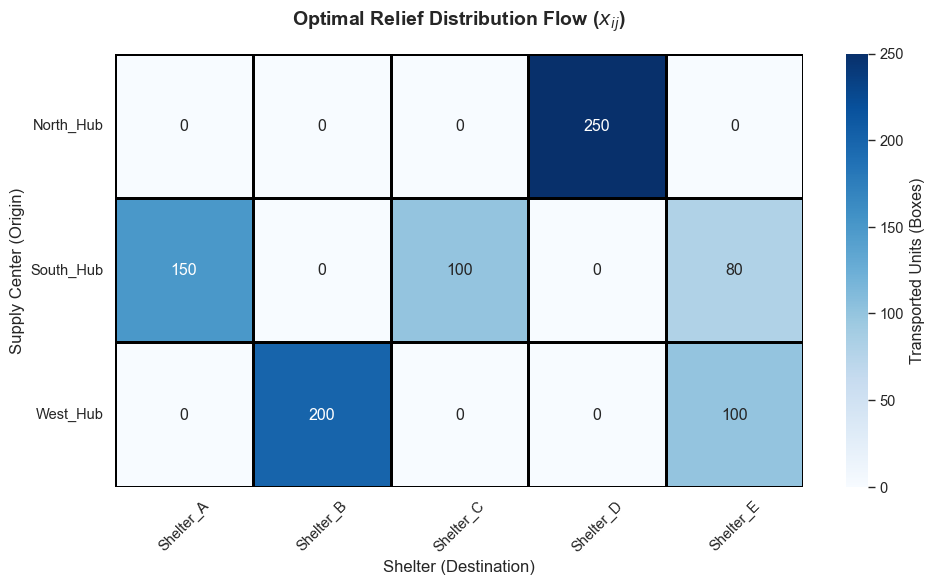

✅ 可视化已生成: Optimal_Flow_Heatmap.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------------------------------------
# Phase 5: 学术可视化 (Academic Visualization)
# ---------------------------------------------------------

# 确保 solver 已求解 (状态为 Optimal)
if solver.status == 'Optimal':
    # 1. 获取结果并清洗
    df_res = solver.get_results_df()
    # 去除 PuLP 自动添加的 "Var_" 前缀以匹配原始 ID
    df_res['Route_ID'] = df_res['Variable'].apply(lambda x: x.replace('Var_', ''))
    
    # 合并原始数据以获取 Origin/Destination
    df_viz = df_res.merge(df, on='Route_ID', how='left')
    
    # 2. 数据透视：构建 [Origin x Destination] 流量矩阵
    matrix_flow = df_viz.pivot_table(
        index='Origin', 
        columns='Destination', 
        values='Value', 
        aggfunc='sum'
    ).fillna(0) # 填充空值为0

    # 3. 绘图设置 (学术风格)
    plt.figure(figsize=(10, 6))
    sns.set_context("paper", font_scale=1.2) # 调整字体适配论文
    sns.set_style("white") 
    
    # 4. 绘制热力图
    # cmap='Blues': 经典的学术单色系，打印友好
    # annot=True: 显示具体运输量
    # fmt=".0f": 不显示小数
    ax = sns.heatmap(
        matrix_flow, 
        annot=True, 
        fmt=".0f", 
        cmap="Blues", 
        linewidths=1, 
        linecolor='black', # 网格线增加对比度
        cbar_kws={'label': 'Transported Units (Boxes)'}
    )

    # 5. 图表修饰
    plt.title('Optimal Relief Distribution Flow ($x_{ij}$)', fontsize=14, pad=20, weight='bold')
    plt.xlabel('Shelter (Destination)', fontsize=12)
    plt.ylabel('Supply Center (Origin)', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # 保存高清大图
    plt.savefig('Optimal_Flow_Heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 可视化已生成: Optimal_Flow_Heatmap.png")

else:
    print("⚠️ 无法绘图: 模型未求解或无最优解。")